## First Configuration

In [1]:
# Install required packages
!pip install neo4j==5.15.0 requests==2.31.0 -q
print("✓ Dependencies installed")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.5/196.5 kB 6.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 kB 3.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.31.0 which is incompatible.
google-adk 1.20.0 requires requests<3.0.0,>=2.32.4, but you have requests 2.31.0 which is incompatible.
datasets 4.0.0 requires requests>=2.32.2, but you have requests 2.31.0 which is incompatible.
✓ Dependencies installed


In [ ]:
# Configuration
import os

# Neo4j Configuration
NEO4J_URI = "bolt://13.219.202.43"  # Change to your Neo4j URI (e.g., Neo4j Aura: bolt://xxx.databases.neo4j.io)
NEO4J_USERNAME = "neo4j"  # Change to your username
NEO4J_PASSWORD = ""  # Change to your password


print("Configuration:")
print(f"  Neo4j URI: {NEO4J_URI}")


Configuration:
  Neo4j URI: bolt://13.219.202.43


## Upload and Parse LLM Response Files

In [3]:
# Upload LLM response files
from google.colab import files
import json
import re

print("Upload your LLM response file:")
print("  - llm_responses_split.json (list of llm_responses per session)")
print("\nClick the button below to upload...")

uploaded = files.upload()

# Get the uploaded file name
uploaded_filename = list(uploaded.keys())[0] if uploaded else None

if uploaded_filename:
    print(f"\nFile uploaded: {uploaded_filename}")
    print(f"  Size: {len(uploaded[uploaded_filename])} bytes")
else:
    print("\n✗ No file uploaded")

Upload your LLM response file:
  - llm_responses_split.json (list of llm_responses per session)

Click the button below to upload...


Saving llm_responses_split.json to llm_responses_split.json

File uploaded: llm_responses_split.json
  Size: 1214254 bytes


In [4]:
# Helper functions for parsing #
def extract_json_from_response(text):
    """Extract JSON from LLM response that may contain markdown or extra text"""
    if not text:
        return None
    # Try to find JSON object in the response
    json_match = re.search(r'\{.*\}', text, re.DOTALL)
    if json_match:
        return json_match.group(0)
    return text

def parse_llm_response_string(response_str):
    """Parse a single LLM response string into a dict"""
    if not response_str:
        return {"entities": [], "events": [], "relationships": []}

    json_text = extract_json_from_response(response_str)
    try:
        data = json.loads(json_text)
        # Ensure all required keys exist
        if "entities" not in data:
            data["entities"] = []
        if "events" not in data:
            data["events"] = []
        if "relationships" not in data:
            data["relationships"] = []
        return data
    except json.JSONDecodeError as e:
        print(f"Warning: Failed to parse JSON response: {e}")
        return {"entities": [], "events": [], "relationships": []}

def add_session_date_to_items(items, session_date):
    """Add session_date to each item in the list"""
    for item in items:
        item["session_date"] = session_date
    return items


In [5]:
# Load and parse the uploaded file
if uploaded_filename:
    # Load JSON file
    with open(uploaded_filename, 'r', encoding='utf-8') as f:
        data = json.load(f)

    print(f"File loaded successfully")
    print(f"Type: {type(data)}")

    # Determine file format
    if isinstance(data, list) and len(data) > 0:
        first_item = data[0]

        # Check if it's the "all_in_one" format (single llm_response string)
        if isinstance(first_item.get("llm_response"), str):
            file_format = "all_in_one"
            print(f"  Format: all_in_one (single llm_response per session)")
        # Check if it's the "split" format (list of llm_response strings)
        elif isinstance(first_item.get("llm_response"), list):
            file_format = "split"
            print(f"  Format: split (list of llm_responses per session)")
        else:
            file_format = "unknown"
            print(f"  Format: unknown (llm_response type: {type(first_item.get('llm_response'))})")
    else:
        file_format = "unknown"
        print(f"  Format: unknown (not a list)")

    print(f"  Number of sessions: {len(data)}")

    # Parse all sessions
    parsed_sessions = []

    for session_idx, session in enumerate(data):
        session_date = session.get("session_date", "")
        session_index = session.get("session_index", session_idx)

        if file_format == "all_in_one":
            # Single llm_response string
            llm_response_str = session.get("llm_response", "")
            parsed_data = parse_llm_response_string(llm_response_str)

            # Add session_date to all items
            parsed_data["entities"] = add_session_date_to_items(parsed_data.get("entities", []), session_date)
            parsed_data["events"] = add_session_date_to_items(parsed_data.get("events", []), session_date)
            parsed_data["relationships"] = add_session_date_to_items(parsed_data.get("relationships", []), session_date)

            parsed_sessions.append({
                "session_index": session_index,
                "session_date": session_date,
                "extraction": parsed_data
            })

        elif file_format == "split":
            # List of llm_response strings - merge them all
            llm_responses = session.get("llm_response", [])

            # Combine all extractions from this session
            combined_entities = []
            combined_events = []
            combined_relationships = []

            for llm_response_str in llm_responses:
                parsed_data = parse_llm_response_string(llm_response_str)

                # Add session_date and merge
                combined_entities.extend(add_session_date_to_items(parsed_data.get("entities", []), session_date))
                combined_events.extend(add_session_date_to_items(parsed_data.get("events", []), session_date))
                combined_relationships.extend(add_session_date_to_items(parsed_data.get("relationships", []), session_date))

            parsed_sessions.append({
                "session_index": session_index,
                "session_date": session_date,
                "extraction": {
                    "entities": combined_entities,
                    "events": combined_events,
                    "relationships": combined_relationships
                }
            })

        if (session_idx + 1) % 10 == 0:
            print(f"  Parsed {session_idx + 1}/{len(data)} sessions...")

    print(f"\nParsing completed!")
    print(f"  Total sessions parsed: {len(parsed_sessions)}")

    # Show summary statistics
    total_entities = sum(len(s["extraction"]["entities"]) for s in parsed_sessions)
    total_events = sum(len(s["extraction"]["events"]) for s in parsed_sessions)
    total_relationships = sum(len(s["extraction"]["relationships"]) for s in parsed_sessions)

    print(f"\nSummary:")
    print(f"  Total entities: {total_entities}")
    print(f"  Total events: {total_events}")
    print(f"  Total relationships: {total_relationships}")

    # Show first session as example
    if parsed_sessions:
        print(f"\nExample (first session):")
        first = parsed_sessions[0]
        print(f"  Session index: {first['session_index']}")
        print(f"  Session date: {first['session_date']}")
        print(f"  Entities: {len(first['extraction']['entities'])}")
        print(f"  Events: {len(first['extraction']['events'])}")
        print(f"  Relationships: {len(first['extraction']['relationships'])}")

        if first['extraction']['entities']:
            print(f"\n  Sample entity: {first['extraction']['entities'][0]}")
else:
    print("No file uploaded. Please upload a file first.")

File loaded successfully
Type: <class 'list'>
  Format: split (list of llm_responses per session)
  Number of sessions: 114
  Parsed 10/114 sessions...
  Parsed 20/114 sessions...
  Parsed 30/114 sessions...
  Parsed 40/114 sessions...
  Parsed 50/114 sessions...
  Parsed 60/114 sessions...
  Parsed 70/114 sessions...
  Parsed 80/114 sessions...
  Parsed 90/114 sessions...
  Parsed 100/114 sessions...
  Parsed 110/114 sessions...

Parsing completed!
  Total sessions parsed: 114

Summary:
  Total entities: 1823
  Total events: 1149
  Total relationships: 1541

Example (first session):
  Session index: 0
  Session date: 2023/05/21 (Sun) 13:13
  Entities: 14
  Events: 9
  Relationships: 13

  Sample entity: {'name': 'USER', 'type': 'user', 'properties': {}, 'extracted_from': "I've been trying to get back into playing the guitar", 'session_date': '2023/05/21 (Sun) 13:13'}


## Each Session = New User

**IMPORTANT**: Each session gets its own unique user.
- User ID format: `user_session_{session_index}`
- Each session's relationships are linked to its specific user
- This allows tracking which user/session created which relationships

In [6]:
# UPDATED: Simple Neo4j loader - each session gets its own user
from neo4j import GraphDatabase

class SimpleNeo4jLoader:
    """Simplified Neo4j loader - each session = new user"""

    def __init__(self, uri, username, password):
        self.driver = GraphDatabase.driver(uri, auth=(username, password))

    def close(self):
        if self.driver:
            self.driver.close()

    def create_schema(self):
        """Create database schema: constraints and indexes"""
        with self.driver.session() as session:
            session.run("""
                CREATE CONSTRAINT user_id_unique IF NOT EXISTS
                FOR (u:User) REQUIRE u.id IS UNIQUE
            """)
            session.run("""
                CREATE INDEX entity_name_type IF NOT EXISTS
                FOR (e:Entity) ON (e.name, e.type)
            """)
            session.run("""
                CREATE INDEX event_name_type IF NOT EXISTS
                FOR (ev:Event) ON (ev.name, ev.type)
            """)
            session.run("""
                CREATE INDEX event_date IF NOT EXISTS
                FOR (ev:Event) ON (ev.date)
            """)
            print("✓ Schema created/verified")

    def create_user(self, user_id):
        """Create User node - each session gets its own user"""
        with self.driver.session() as session:
            session.run("""
                MERGE (u:User {id: $user_id})
                SET u.created_at = datetime(),
                    u.session_index = $session_index
            """, user_id=user_id, session_index=user_id)
            print(f"✓ User {user_id} created/verified")

    def create_or_merge_entity(self, entity):
        """Create or merge Entity node"""
        name = entity.get("name", "").strip()
        entity_type = entity.get("type", "").strip()
        properties = entity.get("properties", {})
        extracted_from = entity.get("extracted_from", "")
        session_date = entity.get("session_date", "")

        if not name or not entity_type:
            return

        props = properties.copy()
        props["extracted_from"] = extracted_from
        props["session_date"] = session_date

        with self.driver.session() as session:
            session.run("""
                MERGE (e:Entity {name: $name, type: $type})
                SET e += $properties
            """, name=name, type=entity_type, properties=props)

    def create_or_merge_event(self, event):
        """Create or merge Event node"""
        name = event.get("name", "").strip()
        event_type = event.get("type", "").strip()
        date = event.get("date", "")
        location = event.get("location", "")
        properties = event.get("properties", {})
        extracted_from = event.get("extracted_from", "")
        session_date = event.get("session_date", "")

        if not name or not event_type:
            return

        props = properties.copy()
        props["extracted_from"] = extracted_from
        props["session_date"] = session_date
        if date:
            props["date"] = date
        if location:
            props["location"] = location

        with self.driver.session() as session:
            session.run("""
                MERGE (ev:Event {name: $name, type: $type})
                SET ev += $properties
            """, name=name, type=event_type, properties=props)

    def create_relationship(self, rel, user_id):
        """Create relationship - user_id is passed per session"""
        source = rel.get("source", "").strip()
        target = rel.get("target", "").strip()
        rel_type = rel.get("type", "").strip()
        properties = rel.get("properties", {})

        if not source or not target or not rel_type:
            return

        with self.driver.session() as session:
            if source.upper() == "USER":
                # User → Entity
                session.run(f"""
                    MATCH (u:User {{id: $user_id}})
                    MATCH (e:Entity {{name: $target}})
                    MERGE (u)-[r:{rel_type}]->(e)
                    SET r += $properties
                """, user_id=user_id, target=target, properties=properties)
                # User → Event
                session.run(f"""
                    MATCH (u:User {{id: $user_id}})
                    MATCH (ev:Event {{name: $target}})
                    MERGE (u)-[r:{rel_type}]->(ev)
                    SET r += $properties
                """, user_id=user_id, target=target, properties=properties)
            else:
                # Entity → Entity
                session.run(f"""
                    MATCH (e1:Entity {{name: $source}})
                    MATCH (e2:Entity {{name: $target}})
                    MERGE (e1)-[r:{rel_type}]->(e2)
                    SET r += $properties
                """, source=source, target=target, properties=properties)
                # Event → Event
                session.run(f"""
                    MATCH (e1:Event {{name: $source}})
                    MATCH (e2:Event {{name: $target}})
                    MERGE (e1)-[r:{rel_type}]->(e2)
                    SET r += $properties
                """, source=source, target=target, properties=properties)
                # Event → Entity
                session.run(f"""
                    MATCH (ev:Event {{name: $source}})
                    MATCH (e:Entity {{name: $target}})
                    MERGE (ev)-[r:{rel_type}]->(e)
                    SET r += $properties
                """, source=source, target=target, properties=properties)

    def load_extraction(self, extraction_data, user_id):
        """Load extraction - user_id is session-specific"""
        for entity in extraction_data.get("entities", []):
            self.create_or_merge_entity(entity)
        for event in extraction_data.get("events", []):
            self.create_or_merge_event(event)
        for rel in extraction_data.get("relationships", []):
            self.create_relationship(rel, user_id)


In [7]:
def load_session_to_neo4j(session_id, parsed_sessions=None, neo4j_uri=None, neo4j_username=None, neo4j_password=None):
    """
    Load a specific session into Neo4j by session ID.

    Args:
        session_id: Session index (int) or session_index value to find the session
        parsed_sessions: List of parsed sessions (defaults to global 'parsed_sessions' if available)
        neo4j_uri: Neo4j URI (defaults to global NEO4J_URI)
        neo4j_username: Neo4j username (defaults to global NEO4J_USERNAME)
        neo4j_password: Neo4j password (defaults to global NEO4J_PASSWORD)

    Returns:
        dict: Results with 'success', 'user_id', 'session_index', 'session_date',
              'entities', 'events', 'relationships', and 'error' (if failed)
    """
    # Use globals if not provided
    if parsed_sessions is None:
        if 'parsed_sessions' not in globals():
            return {
                'success': False,
                'error': 'No parsed_sessions available. Please run the file upload and parsing cells first.',
                'user_id': None
            }
        parsed_sessions = globals()['parsed_sessions']

    if neo4j_uri is None:
        neo4j_uri = globals().get('NEO4J_URI', None)
    if neo4j_username is None:
        neo4j_username = globals().get('NEO4J_USERNAME', None)
    if neo4j_password is None:
        neo4j_password = globals().get('NEO4J_PASSWORD', None)

    if not parsed_sessions:
        return {
            'success': False,
            'error': 'No parsed sessions available.',
            'user_id': None
        }

    if neo4j_uri is None or neo4j_username is None or neo4j_password is None:
        return {
            'success': False,
            'error': 'Neo4j configuration missing. Please set NEO4J_URI, NEO4J_USERNAME, and NEO4J_PASSWORD.',
            'user_id': None
        }

    # Find the session by session_id
    selected_session = None

    # Try to find by list index first (if session_id is an integer)
    if isinstance(session_id, int) and 0 <= session_id < len(parsed_sessions):
        selected_session = parsed_sessions[session_id]
        print(f"✓ Found session at index {session_id}")
    else:
        # Try to find by session_index value
        for session in parsed_sessions:
            if session.get('session_index') == session_id:
                selected_session = session
                print(f"✓ Found session with session_index {session_id}")
                break

    if selected_session is None:
        return {
            'success': False,
            'error': f'Session ID {session_id} not found. Available sessions: 0-{len(parsed_sessions)-1}',
            'user_id': None
        }

    # Extract session data
    session_index = selected_session['session_index']
    session_date = selected_session['session_date']
    single_session_extraction = selected_session['extraction']

    print(f"\nSelected session:")
    print(f"  Session Index: {session_index}")
    print(f"  Session Date: {session_date}")
    print(f"  Entities: {len(single_session_extraction['entities'])}")
    print(f"  Events: {len(single_session_extraction['events'])}")
    print(f"  Relationships: {len(single_session_extraction['relationships'])}")

    # Load into Neo4j
    print("\nConnecting to Neo4j and loading session...")

    loader = SimpleNeo4jLoader(neo4j_uri, neo4j_username, neo4j_password)

    try:
        loader.driver.verify_connectivity()
        print("✓ Connected to Neo4j")

        loader.create_schema()

        # Create unique user for this session
        user_id = f"user_session_{session_index}"
        loader.create_user(user_id)

        # Load with session-specific user_id
        print(f"\nLoading session into Neo4j...")
        print(f"  User ID: {user_id}")
        loader.load_extraction(single_session_extraction, user_id)

        print(f"\n✓ Session loaded successfully!")
        print(f"  User ID: {user_id}")
        print(f"  Entities: {len(single_session_extraction['entities'])}")
        print(f"  Events: {len(single_session_extraction['events'])}")
        print(f"  Relationships: {len(single_session_extraction['relationships'])}")

        return {
            'success': True,
            'user_id': user_id,
            'session_index': session_index,
            'session_date': session_date,
            'entities': len(single_session_extraction['entities']),
            'events': len(single_session_extraction['events']),
            'relationships': len(single_session_extraction['relationships']),
            'error': None
        }

    except Exception as e:
        error_msg = f"Error loading session: {str(e)}"
        print(f"✗ {error_msg}")
        import traceback
        traceback.print_exc()
        return {
            'success': False,
            'error': error_msg,
            'user_id': None
        }
    finally:
        loader.close()
        print("✓ Connection closed")


print("Function 'load_session_to_neo4j' defined")
print("\nUsage: result = load_session_to_neo4j(session_id)")
print("  Example: load_session_to_neo4j(0)  # Load first session")
print("  Example: load_session_to_neo4j(5)  # Load session at index 5")

Function 'load_session_to_neo4j' defined

Usage: result = load_session_to_neo4j(session_id)
  Example: load_session_to_neo4j(0)  # Load first session
  Example: load_session_to_neo4j(5)  # Load session at index 5


## Automated Pipeline: Load, Display Structure, and Visualize


In [8]:
def pipeline_load_and_visualize(session_id, parsed_sessions=None, neo4j_uri=None,
                                 neo4j_username=None, neo4j_password=None,
                                 show_structure=True, show_visualization=True):
    """
    Complete pipeline: Load session to Neo4j, display graph structure, and visualize.

    Args:
        session_id: Session index (int) or session_index value to find the session
        parsed_sessions: List of parsed sessions (defaults to global 'parsed_sessions')
        neo4j_uri: Neo4j URI (defaults to global NEO4J_URI)
        neo4j_username: Neo4j username (defaults to global NEO4J_USERNAME)
        neo4j_password: Neo4j password (defaults to global NEO4J_PASSWORD)
        show_structure: Whether to print graph structure (default: True)
        show_visualization: Whether to show visualization (default: True)

    Returns:
        dict: Results from loading session and visualization
    """
    from neo4j import GraphDatabase

    print("=" * 80)
    print("AUTOMATED PIPELINE: Load Session → Display Structure → Visualize")
    print("=" * 80)
    print(f"\n📥 Step 1: Loading session {session_id} to Neo4j...")
    print("-" * 80)

    # Step 1: Load session to Neo4j
    load_result = load_session_to_neo4j(session_id, parsed_sessions, neo4j_uri,
                                         neo4j_username, neo4j_password)

    if not load_result['success']:
        print(f"\n✗ Pipeline failed at loading step: {load_result['error']}")
        return {'success': False, 'load_result': load_result, 'error': load_result['error']}

    user_id = load_result['user_id']
    print(f"\n✓ Step 1 completed successfully!")
    print(f"  User ID: {user_id}")

    # Use globals if not provided
    if neo4j_uri is None:
        neo4j_uri = globals().get('NEO4J_URI', None)
    if neo4j_username is None:
        neo4j_username = globals().get('NEO4J_USERNAME', None)
    if neo4j_password is None:
        neo4j_password = globals().get('NEO4J_PASSWORD', None)

    # Step 2: Display graph structure
    if show_structure:
        print(f"\n📊 Step 2: Displaying graph structure...")
        print("-" * 80)

        driver = GraphDatabase.driver(neo4j_uri, auth=(neo4j_username, neo4j_password))

        try:
            print("\n" + "=" * 70)
            print("GRAPH STRUCTURE IN NEO4J:")
            print("=" * 70)

            with driver.session() as session:
                # Get all nodes
                print("\n📊 NODES:")
                print("-" * 70)

                # User nodes
                result = session.run("MATCH (u:User) RETURN u.id as id, properties(u) as props")
                users = []
                for record in result:
                    users.append(record)
                    print(f"  👤 User: {record['id']}")
                    props = {k: v for k, v in record['props'].items() if k != 'id'}
                    if props:
                        print(f"     Properties: {props}")

                # Entity nodes
                result = session.run("""
                    MATCH (e:Entity)
                    RETURN e.name as name, e.type as type, e.session_date as session_date,
                           e.extracted_from as extracted_from
                    ORDER BY e.type, e.name
                    LIMIT 50
                """)
                entities = []
                for record in result:
                    entities.append(record)
                    print(f"  📦 Entity: {record['name']} (type: {record['type']})")
                    if record['session_date']:
                        print(f"     Session Date: {record['session_date']}")
                    if record['extracted_from']:
                        print(f"     Extracted from: {record['extracted_from'][:80]}...")

                # Event nodes
                result = session.run("""
                    MATCH (ev:Event)
                    RETURN ev.name as name, ev.type as type, ev.session_date as session_date,
                           ev.extracted_from as extracted_from
                    ORDER BY ev.type, ev.name
                    LIMIT 50
                """)
                events = []
                for record in result:
                    events.append(record)
                    print(f"  🎯 Event: {record['name']} (type: {record['type']})")
                    if record['session_date']:
                        print(f"     Session Date: {record['session_date']}")
                    if record['extracted_from']:
                        print(f"     Extracted from: {record['extracted_from'][:80]}...")

                # Get relationships - always show all relationships
                print("\n🔗 RELATIONSHIPS:")
                print("-" * 70)

                result = session.run("""
                    MATCH (source)-[r]->(target)
                    RETURN labels(source)[0] as source_label, source.name as source_name,
                           CASE WHEN source.name IS NOT NULL THEN source.name ELSE source.id END as source_display,
                           type(r) as rel_type,
                           labels(target)[0] as target_label, target.name as target_name,
                           CASE WHEN target.name IS NOT NULL THEN target.name ELSE target.id END as target_display,
                           properties(r) as props
                    ORDER BY source_label, rel_type
                    LIMIT 100
                """)

                relationships = []
                for record in result:
                    relationships.append(record)
                    props_str = ""
                    if record['props']:
                        props_str = f" [{', '.join(f'{k}: {v}' for k, v in record['props'].items())}]"
                    print(f"  {record['source_label']}:{record['source_display']} --[{record['rel_type']}{props_str}]--> {record['target_label']}:{record['target_display']}")

            print("\n✓ Graph structure displayed!")
            print(f"  Total Users: {len(users)}")
            print(f"  Total Entities: {len(entities)}")
            print(f"  Total Events: {len(events)}")
            print(f"  Total Relationships: {len(relationships)}")

        finally:
            driver.close()

    # Step 3: Visualize graph
    if show_visualization:
        print(f"\n🎨 Step 3: Visualizing graph...")
        print("-" * 80)

        try:
            import matplotlib.pyplot as plt
            import networkx as nx

            # Install if needed
            try:
                import networkx
            except ImportError:
                print("Installing networkx and matplotlib...")
                import subprocess
                subprocess.check_call(["pip", "install", "networkx", "matplotlib", "-q"])
                import networkx as nx
                import matplotlib.pyplot as plt

            driver = GraphDatabase.driver(neo4j_uri, auth=(neo4j_username, neo4j_password))

            # Query graph data - always show ALL nodes and edges for visualization
            with driver.session() as session:
                # Get all nodes
                nodes_result = session.run("""
                    MATCH (n)
                    WHERE n:User OR n:Entity OR n:Event
                    RETURN labels(n)[0] as label, n.name as name, n.type as type, n.id as id
                """)
                nodes = []
                for record in nodes_result:
                    if record['name'] or record['id']:  # Skip None nodes
                        node_name = record['name'] if record['name'] else record['id']
                        node_type = record['type'] if record['type'] else record['label']
                        nodes.append((node_name, record['label'], node_type))

                # Get all relationships
                edges_result = session.run("""
                    MATCH (source)-[r]->(target)
                    RETURN
                        CASE WHEN source.name IS NOT NULL THEN source.name ELSE source.id END as from_name,
                        CASE WHEN target.name IS NOT NULL THEN target.name ELSE target.id END as to_name,
                        type(r) as rel_type,
                        labels(source)[0] as from_label,
                        labels(target)[0] as to_label
                """)
                edges = []
                for record in edges_result:
                    if record['from_name'] and record['to_name']:  # Skip None values
                        edges.append((record['from_name'], record['to_name'], record['rel_type'],
                                     record['from_label'], record['to_label']))

            driver.close()

            # Debug: Print what we got
            print(f"\n📊 Visualization Data:")
            print(f"  Nodes found: {len(nodes)}")
            print(f"  Edges found: {len(edges)}")
            if nodes:
                print(f"  Sample nodes: {nodes[:3]}")
            if edges:
                print(f"  Sample edges: {edges[:3]}")

            # Create NetworkX graph
            G = nx.DiGraph()

            # Add nodes with metadata
            node_metadata = {}
            for name, label, node_type in nodes:
                G.add_node(name, label=label, node_type=node_type)
                node_metadata[name] = {'label': label, 'type': node_type}

            print(f"  Nodes in graph: {len(G.nodes())}")

            # Add edges with relationship types
            edges_added = 0
            for from_node, to_node, rel_type, from_label, to_label in edges:
                if from_node in G and to_node in G:
                    G.add_edge(from_node, to_node, rel_type=rel_type)
                    edges_added += 1
                elif from_node is None or to_node is None:
                    print(f"  ⚠ Skipping edge with None: {from_node} -> {to_node}")

            print(f"  Edges added to graph: {edges_added}")

            # Create visualization
            plt.figure(figsize=(16, 12))

            # Use spring layout for better positioning
            if len(G.nodes()) > 0:
                pos = nx.spring_layout(G, k=3, iterations=50, seed=42)

                # Color nodes by label
                node_colors = []
                color_map = {
                    'User': '#FF6B6B',
                    'Entity': '#4ECDC4',
                    'Event': '#95E1D3'
                }
                for node in G.nodes():
                    label = node_metadata[node]['label']
                    node_colors.append(color_map.get(label, '#CCCCCC'))

                # Draw nodes
                nx.draw_networkx_nodes(G, pos, node_color=node_colors,
                                      node_size=1500, alpha=0.9)

                # Draw edges
                nx.draw_networkx_edges(G, pos, edge_color='gray',
                                      arrows=True, arrowsize=15, alpha=0.6,
                                      connectionstyle='arc3,rad=0.1', width=1.5)

                # Draw labels (truncate long names)
                labels = {node: node[:20] + '...' if len(node) > 20 else node
                         for node in G.nodes()}
                nx.draw_networkx_labels(G, pos, labels, font_size=8, font_weight='bold')

                # Draw edge labels (relationship types) - only for a subset to avoid clutter
                edge_labels = {}
                for u, v, data in G.edges(data=True):
                    if len(edge_labels) < 30:  # Limit to first 30 edges
                        edge_labels[(u, v)] = data['rel_type']
                nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=7, alpha=0.7)

                plt.title(f"Neo4j Graph Visualization - Session {session_id}\n({len(G.nodes())} nodes, {len(G.edges())} relationships)",
                         fontsize=16, fontweight='bold')
                plt.axis('off')
                plt.tight_layout()
                plt.show()

                print(f"✓ Graph visualization displayed!")
                print(f"  Nodes: {len(G.nodes())}")
                print(f"  Edges: {len(G.edges())}")
            else:
                print("⚠ No nodes found in the graph")

        except ImportError as e:
            print(f"Visualization libraries not available: {e}")
            print("Graph structure shown in text format above.")
        except Exception as e:
            print(f"Error creating visualization: {e}")
            import traceback
            traceback.print_exc()
            print("Graph structure shown in text format above.")

    print("\n" + "=" * 80)
    print("✓ PIPELINE COMPLETED SUCCESSFULLY!")
    print("=" * 80)
    print(f"  Session ID: {session_id}")
    print(f"  User ID: {user_id}")
    print(f"  Entities: {load_result['entities']}")
    print(f"  Events: {load_result['events']}")
    print(f"  Relationships: {load_result['relationships']}")
    print("=" * 80)

    return {
        'success': True,
        'load_result': load_result,
        'user_id': user_id
    }


print("✓ Function 'pipeline_load_and_visualize' defined")
print("\nUsage: pipeline_load_and_visualize(session_id)")
print("  Example: pipeline_load_and_visualize(0)  # Complete pipeline for session 0")


✓ Function 'pipeline_load_and_visualize' defined

Usage: pipeline_load_and_visualize(session_id)
  Example: pipeline_load_and_visualize(0)  # Complete pipeline for session 0


## Run the Pipeline


AUTOMATED PIPELINE: Load Session → Display Structure → Visualize

📥 Step 1: Loading session 0 to Neo4j...
--------------------------------------------------------------------------------
✓ Found session at index 0

Selected session:
  Session Index: 0
  Session Date: 2023/05/21 (Sun) 13:13
  Entities: 14
  Events: 9
  Relationships: 13

Connecting to Neo4j and loading session...
✓ Connected to Neo4j
✓ Schema created/verified
✓ User user_session_0 created/verified

Loading session into Neo4j...
  User ID: user_session_0

✓ Session loaded successfully!
  User ID: user_session_0
  Entities: 14
  Events: 9
  Relationships: 13
✓ Connection closed

✓ Step 1 completed successfully!
  User ID: user_session_0

📊 Step 2: Displaying graph structure...
--------------------------------------------------------------------------------

GRAPH STRUCTURE IN NEO4J:

📊 NODES:
----------------------------------------------------------------------
  👤 User: user_session_0
     Properties: {'created_at': neo

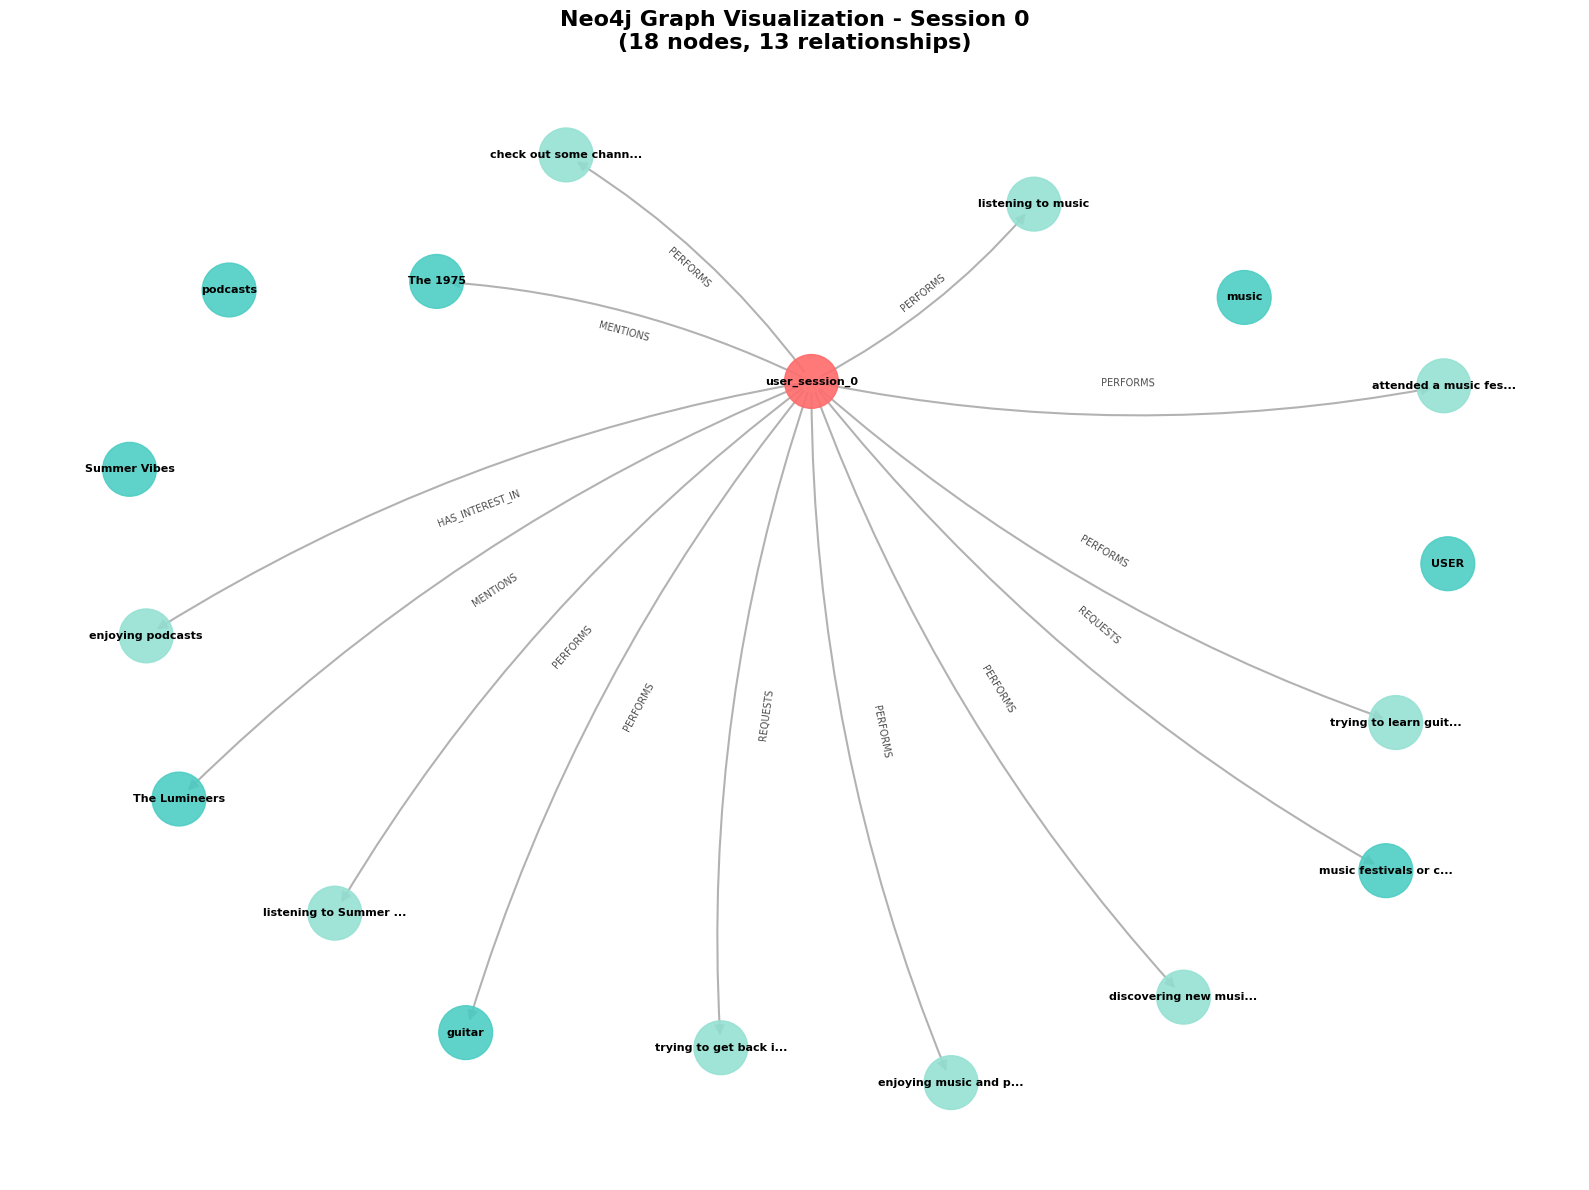

✓ Graph visualization displayed!
  Nodes: 18
  Edges: 13

✓ PIPELINE COMPLETED SUCCESSFULLY!
  Session ID: 0
  User ID: user_session_0
  Entities: 14
  Events: 9
  Relationships: 13


{'success': True,
 'load_result': {'success': True,
  'user_id': 'user_session_0',
  'session_index': 0,
  'session_date': '2023/05/21 (Sun) 13:13',
  'entities': 14,
  'events': 9,
  'relationships': 13,
  'error': None},
 'user_id': 'user_session_0'}

In [9]:
# Run the complete pipeline for a session
# This will: 1) Load the session, 2) Display graph structure, 3) Show visualization

# Example: Process session 0
pipeline_load_and_visualize(0)

AUTOMATED PIPELINE: Load Session → Display Structure → Visualize

📥 Step 1: Loading session 5 to Neo4j...
--------------------------------------------------------------------------------
✓ Found session at index 5

Selected session:
  Session Index: 5
  Session Date: 2023/05/28 (Sun) 17:03
  Entities: 15
  Events: 11
  Relationships: 13

Connecting to Neo4j and loading session...
✓ Connected to Neo4j
✓ Schema created/verified
✓ User user_session_5 created/verified

Loading session into Neo4j...
  User ID: user_session_5

✓ Session loaded successfully!
  User ID: user_session_5
  Entities: 15
  Events: 11
  Relationships: 13
✓ Connection closed

✓ Step 1 completed successfully!
  User ID: user_session_5

📊 Step 2: Displaying graph structure...
--------------------------------------------------------------------------------

GRAPH STRUCTURE IN NEO4J:

📊 NODES:
----------------------------------------------------------------------
  👤 User: user_session_0
     Properties: {'created_at': n

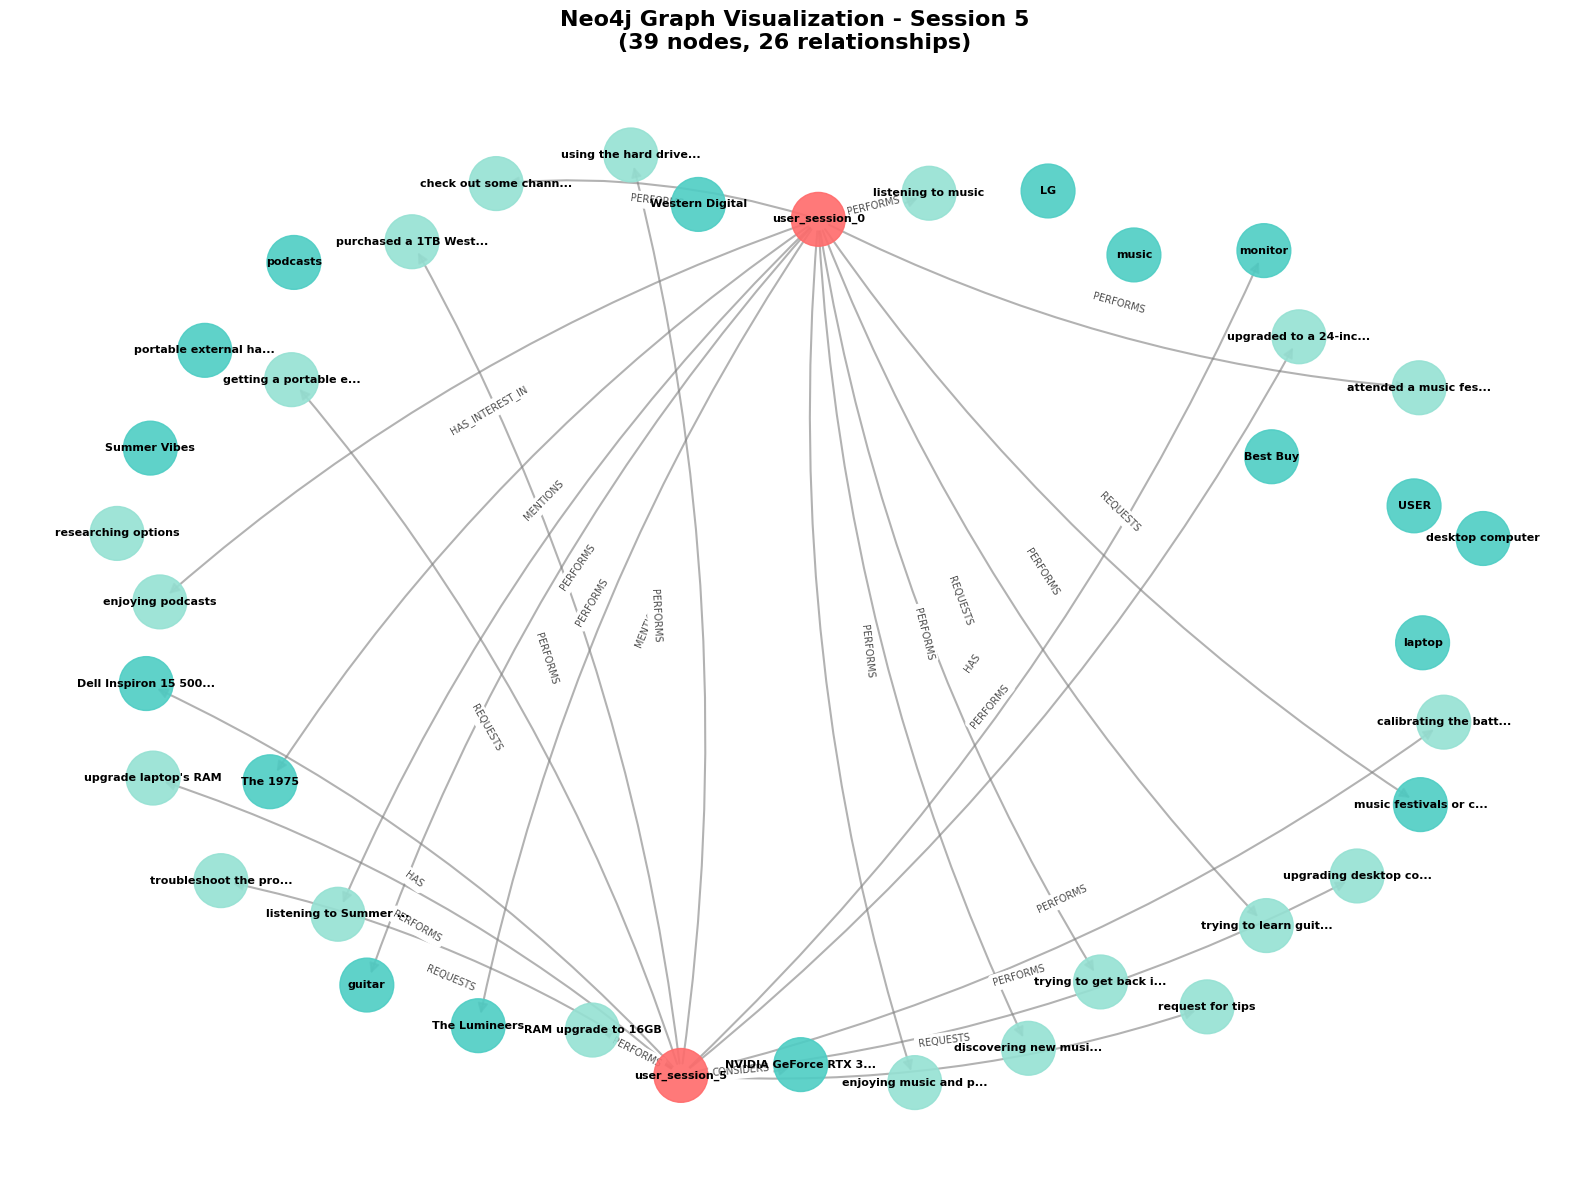

✓ Graph visualization displayed!
  Nodes: 39
  Edges: 26

✓ PIPELINE COMPLETED SUCCESSFULLY!
  Session ID: 5
  User ID: user_session_5
  Entities: 15
  Events: 11
  Relationships: 13


{'success': True,
 'load_result': {'success': True,
  'user_id': 'user_session_5',
  'session_index': 5,
  'session_date': '2023/05/28 (Sun) 17:03',
  'entities': 15,
  'events': 11,
  'relationships': 13,
  'error': None},
 'user_id': 'user_session_5'}

In [10]:
pipeline_load_and_visualize(5)


In [11]:
pipeline_load_and_visualize(18, show_structure=False, show_visualization=False)


AUTOMATED PIPELINE: Load Session → Display Structure → Visualize

📥 Step 1: Loading session 18 to Neo4j...
--------------------------------------------------------------------------------
✓ Found session at index 18

Selected session:
  Session Index: 18
  Session Date: 2023/05/25 (Thu) 06:04
  Entities: 26
  Events: 14
  Relationships: 17

Connecting to Neo4j and loading session...
✓ Connected to Neo4j
✓ Schema created/verified
✓ User user_session_18 created/verified

Loading session into Neo4j...
  User ID: user_session_18

✓ Session loaded successfully!
  User ID: user_session_18
  Entities: 26
  Events: 14
  Relationships: 17
✓ Connection closed

✓ Step 1 completed successfully!
  User ID: user_session_18

✓ PIPELINE COMPLETED SUCCESSFULLY!
  Session ID: 18
  User ID: user_session_18
  Entities: 26
  Events: 14
  Relationships: 17


{'success': True,
 'load_result': {'success': True,
  'user_id': 'user_session_18',
  'session_index': 18,
  'session_date': '2023/05/25 (Thu) 06:04',
  'entities': 26,
  'events': 14,
  'relationships': 17,
  'error': None},
 'user_id': 'user_session_18'}

In [13]:
for i in range(60):
    pipeline_load_and_visualize(i, show_structure=False, show_visualization=False)

AUTOMATED PIPELINE: Load Session → Display Structure → Visualize

📥 Step 1: Loading session 0 to Neo4j...
--------------------------------------------------------------------------------
✓ Found session at index 0

Selected session:
  Session Index: 0
  Session Date: 2023/05/21 (Sun) 13:13
  Entities: 14
  Events: 9
  Relationships: 13

Connecting to Neo4j and loading session...
✓ Connected to Neo4j
✓ Schema created/verified
✓ User user_session_0 created/verified

Loading session into Neo4j...
  User ID: user_session_0

✓ Session loaded successfully!
  User ID: user_session_0
  Entities: 14
  Events: 9
  Relationships: 13
✓ Connection closed

✓ Step 1 completed successfully!
  User ID: user_session_0

✓ PIPELINE COMPLETED SUCCESSFULLY!
  Session ID: 0
  User ID: user_session_0
  Entities: 14
  Events: 9
  Relationships: 13
AUTOMATED PIPELINE: Load Session → Display Structure → Visualize

📥 Step 1: Loading session 1 to Neo4j...
-----------------------------------------------------------

In [14]:
# Summary statistics
from neo4j import GraphDatabase

driver = GraphDatabase.driver(
    NEO4J_URI,
    auth=(NEO4J_USERNAME, NEO4J_PASSWORD)
)

print("=" * 70)
print("GRAPH STATISTICS:")
print("=" * 70)

with driver.session() as session:
    # Count nodes by type
    result = session.run("MATCH (u:User) RETURN count(u) as count")
    user_count = result.single()["count"]
    print(f"\n👤 User nodes: {user_count}")

    result = session.run("MATCH (e:Entity) RETURN count(e) as count")
    entity_count = result.single()["count"]
    print(f"📦 Entity nodes: {entity_count}")

    result = session.run("MATCH (ev:Event) RETURN count(ev) as count")
    event_count = result.single()["count"]
    print(f"🎯 Event nodes: {event_count}")

    # Count relationships
    result = session.run("MATCH ()-[r]->() RETURN count(r) as count")
    rel_count = result.single()["count"]
    print(f"🔗 Total relationships: {rel_count}")

    # Count relationships by type
    print(f"\n📊 Relationships by type:")
    result = session.run("""
        MATCH ()-[r]->()
        RETURN type(r) as rel_type, count(*) as count
        ORDER BY count DESC
    """)
    for record in result:
        print(f"   {record['rel_type']}: {record['count']}")

    # Entity types distribution
    print(f"\n📊 Entity types distribution:")
    result = session.run("""
        MATCH (e:Entity)
        RETURN e.type as type, count(*) as count
        ORDER BY count DESC
        LIMIT 10
    """)
    for record in result:
        print(f"   {record['type']}: {record['count']}")

    # Event types distribution
    print(f"\n📊 Event types distribution:")
    result = session.run("""
        MATCH (ev:Event)
        RETURN ev.type as type, count(*) as count
        ORDER BY count DESC
        LIMIT 10
    """)
    for record in result:
        print(f"   {record['type']}: {record['count']}")

driver.close()
print("\n✓ Statistics displayed!")

GRAPH STATISTICS:

👤 User nodes: 60
📦 Entity nodes: 432
🎯 Event nodes: 555
🔗 Total relationships: 775

📊 Relationships by type:
   PERFORMS: 356
   REQUESTS: 127
   HAS_INTEREST_IN: 55
   HAS: 47
   TARGETS: 46
   MENTIONS: 18
   CONCERNS: 15
   MET: 15
   PROVIDES_UTILITY_FOR: 12
   PURCHASED: 12
   CONSIDERS: 9
   OWNS: 7
   CREATED: 6
   USES: 6
   ATTENDS: 4
   HAS_RESULTED_IN: 4
   INCLUDES: 3
   VISITED: 3
   EXPERIENCES: 3
   PERFORMED: 3
   RELATED_TO: 3
   HELPS_IMPROVE: 2
   THINKS_ABOUT: 2
   PREFERS: 2
   ATTENDED: 2
   Mentions: 2
   MEETS: 2
   WANTS_TO_KNOW_MORE_ABOUT: 1
   PLANS: 1
   CREATES: 1
   HAS_CONCERNS: 1
   LISTENS_TO: 1
   WANTS_TO_OWN: 1
   WANTS_TO_ADD: 1
   PLANS_TO: 1
   COMPARISON_TO: 1

📊 Entity types distribution:
   object: 203
   organization: 50
   platform: 49
   person: 46
   location: 37
   pet: 20
   event: 11
   degree: 6
   playlist: 6
   color: 2

📊 Event types distribution:
   action: 253
   request: 121
   utility: 95
   purchase: 36
   att

### Delete all users

In [15]:
# Delete all data from Neo4j (reset database)



# Set this to True to proceed with deletion
CONFIRM_DELETE = False  # Change to True to actually delete



from neo4j import GraphDatabase

print("⚠️ WARNING: This will DELETE ALL DATA from Neo4j!")
print("=" * 70)

if CONFIRM_DELETE:
    driver = GraphDatabase.driver(
        NEO4J_URI,
        auth=(NEO4J_USERNAME, NEO4J_PASSWORD)
    )

    try:
        driver.verify_connectivity()
        print("✓ Connected to Neo4j")

        with driver.session() as session:
            # Count before deletion
            result = session.run("MATCH (n) RETURN count(n) as count")
            node_count = result.single()["count"]
            result = session.run("MATCH ()-[r]->() RETURN count(r) as count")
            rel_count = result.single()["count"]

            print(f"\nCurrent database state:")
            print(f"  Nodes: {node_count}")
            print(f"  Relationships: {rel_count}")

            # Delete all relationships first
            print("\n🗑️ Deleting all relationships...")
            result = session.run("MATCH ()-[r]->() DELETE r")
            print(f"✓ Deleted relationships")

            # Delete all nodes
            print("🗑️ Deleting all nodes...")
            result = session.run("MATCH (n) DELETE n")
            print(f"✓ Deleted nodes")

            # Verify deletion
            result = session.run("MATCH (n) RETURN count(n) as count")
            remaining_nodes = result.single()["count"]
            result = session.run("MATCH ()-[r]->() RETURN count(r) as count")
            remaining_rels = result.single()["count"]

            print(f"\n✓ Database reset complete!")
            print(f"  Remaining nodes: {remaining_nodes}")
            print(f"  Remaining relationships: {remaining_rels}")

    finally:
        driver.close()
        print("✓ Connection closed")
else:
    print("\n❌ Deletion cancelled (CONFIRM_DELETE = False)")
    print("   To delete all data, set CONFIRM_DELETE = True in the cell above")

⚠️ WARNING: This will DELETE ALL DATA from Neo4j!

❌ Deletion cancelled (CONFIRM_DELETE = False)
   To delete all data, set CONFIRM_DELETE = True in the cell above
